# Regularization

When training a Neural Network, we want to avoid at all cost overfitting. Overfitting occures when when have overlearned on our training set. The first thing to do is to compare the performances (loss or metrics) of the train dataset with the validation dataset. If you see a gap in performances, this means that you have overfitted your network.

To study the impact of overfitting, we will leverage a synthetic dataset given by the following Dataset.

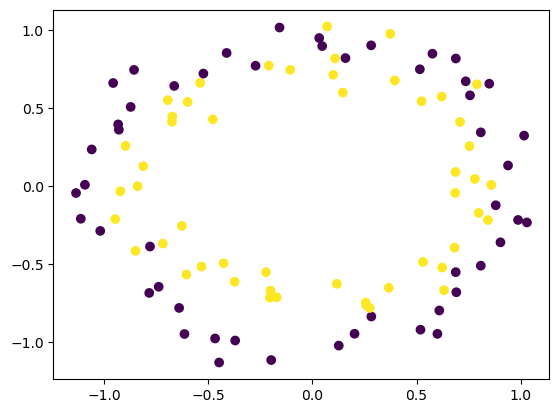

In [63]:
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt
from tqdm import tqdm

class CircleDataset(nn.Module):
    def __init__(self, 
                 num_samples :int , 
                 std : float =0.1, 
                 transform: callable=None, 
                 seed=None):
        
        self.x, self.y = make_circles(
            n_samples=num_samples, 
            noise=std, 
            random_state=seed
        )
        self.x = torch.from_numpy(self.x).float()
        self.y = torch.from_numpy(self.y).float()
        self.len = self.x.shape[0]
        self.transform = transform

        # self.y = torch\
        #     .nn\
        #     .functional\
        #     .one_hot(
        #         self.y.to(torch.int64)
        #     )

        if self.transform:
            self.x = transform(self.x)
    
    
    def __getitem__(self, index):
        # if self.transform:
        #     return self.transform(self.x[index]), self.y[index]
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.len
    
# Plot the dataset
dataset = CircleDataset(100)
plt.scatter(dataset.x[:,0], dataset.x[:,1], c=dataset.y)
plt.show()

In [64]:
dataset.y

tensor([1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 0., 1., 1., 1., 0., 1., 1.,
        0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1.,
        0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0.,
        1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0.,
        0., 1., 0., 1., 1., 0., 1., 1., 1., 0.])

### Question 3
Create a CircleDataset validation and test set with 500 samples, std=0.1. To be able to compare between experiments, use seed 3407 for the validation set and 3408 for the test set. This test set must be the same for every experiment we will do.

Note: Validation and test set are crucial to evaluate the performance of an ML algorithm. The goal is to be able to evaluate the generalisation abilities of our method. Indeed, if we overfit on the train set, we will have optimal performances but our method will not work in out of train set data. 

The validation set is used for both monitoring the evolution of training and to tune hyperparameters.

The test set must be used ONLY at the end of training/hparameters tuning. Otherwise, you risk overfitting on it.

In [181]:
### YOUR CODE HERE
circle_train_dataset = CircleDataset(50,
                                     seed = 34,)

circle_train_loader = DataLoader(circle_train_dataset,
                                     batch_size=64)

circle_val_dataset = CircleDataset(50,
                                   seed = 3407,)

circle_val_loader = DataLoader(circle_val_dataset,
                               batch_size=  64)

### YOUR CODE HERE
circle_test_dataset = CircleDataset(500,
                                    seed = 3408,)
circle_test_loader = DataLoader(circle_test_dataset,
                                batch_size= 64)

### Question 4
Create a Feed Forward architecture with 2 hidden layers of size 500, 500. Use the `BCELoss`, and the Adam optimizer with lr=5e-3. Train for 50000 steps ploting the loss and the accuracy for both the train and val set after each epoch end. Also, compute the accuracy at the end of training on the test set. Train on a new Circle dataset having 50 data points. What can you say about the result?

In [165]:
class FFN(torch.nn.Module):
    def __init__(self,
                 in_features,
                 out_features,
                 init : callable = torch.nn.init.xavier_normal_
                ) -> None:
        super().__init__()

        self.layer1 = torch.nn.Linear(
            in_features,
            500
        )

        self.layer2 = torch.nn.Linear(
            500,
            out_features
        )

        self.relu = torch.nn.ReLU()

        self.sigmoid = torch.nn.Sigmoid()

        self.initialize_weigths(init)

    def initialize_weigths(self, init: callable):
        init(self.layer1.weight)
        init(self.layer2.weight)

    def forward(self, x: torch.Tensor):
        # print(f"size of x: {x.shape}")
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)

        return self.sigmoid(x)

In [182]:
train_losses = []
train_accs = []
val_losses = []
val_accs = []
test_acc = []
model = FFN(2,1)
epochs = 1_000

optimizer = torch.optim.Adam(
    model.parameters(),
    lr = 5e-3
)

loss_fn = torch.nn.BCELoss()
model.train()
for epoch in tqdm(range(epochs)):
    for idx, (X_batch, y_batch) in enumerate(circle_train_loader):
        # X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()

        target = y_batch\
            .unsqueeze(1)\
            .to(torch.float32)
        
        y_pred_train = model(X_batch)
        train_loss = loss_fn(y_pred_train, target)

        train_losses.append(train_loss.detach().item())

        train_accs.append(
            abs(y_pred_train - target) < .5
        )

        train_loss.backward()
        optimizer.step()

    with torch.no_grad():
        for idx, (X_val, y_val ) in enumerate(circle_val_loader):
            # X_val, y_val = X_val.to(device), y_val.to(device)

            y_pred_val = model(X_batch)
            target = y_batch\
                .unsqueeze(1)\
                .to(torch.float32)

            val_loss = loss_fn(y_pred_val, target)

            val_losses.append(val_loss.detach().item())
            
            val_accs.append(
                abs(y_pred_val - target ) <=.5
            )

100%|██████████| 1000/1000 [00:02<00:00, 389.60it/s]


In [168]:
(abs(y_pred_train -target ) < 0.5).sum()/50

tensor(0.9200)

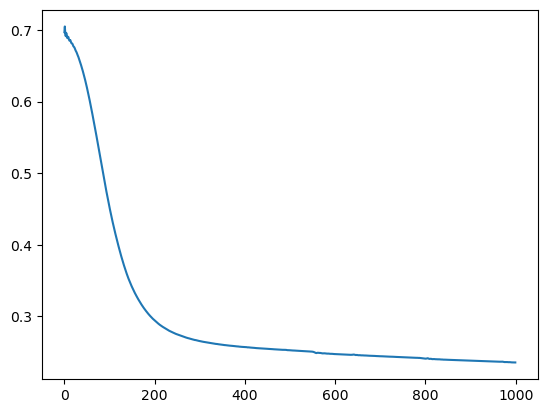

In [169]:

plt.plot(train_losses)

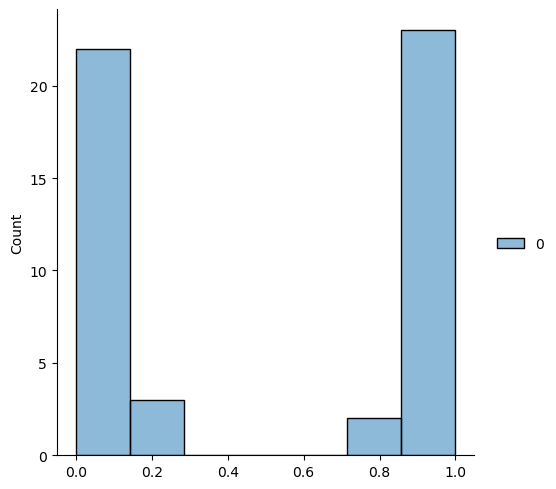

In [152]:
import seaborn as sns
sns.displot(y_pred_train.detach().numpy())

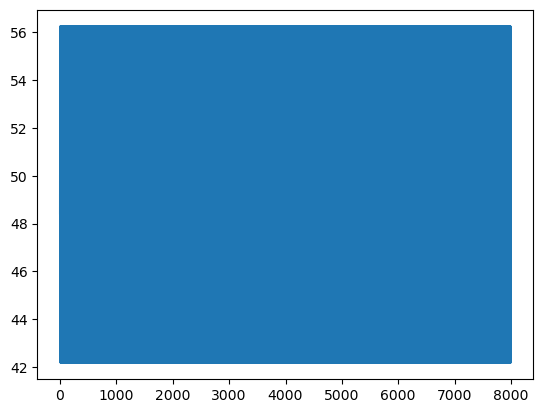

In [90]:
plt.plot(train_losses)

In [68]:
def train(model : torch.nn.Module,
          train_loader : DataLoader, 
          val_loader : DataLoader, 
        #   test_loader : DataLoader, 
          device = 'cpu', 
          epochs=1000):
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    test_acc = []

    optimizer = torch.optim.Adam(
        model.parameters(),
        lr = 5e-3
    )

    loss_fn = torch.nn.BCELoss()
    model.train()
    for epoch in tqdm(range(epochs)):
        for idx, (X_batch, y_batch) in enumerate(train_loader):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()

            target = y_batch\
                .unsqueeze(1)\
                .to(torch.float32)
            y_pred_train = model(X_batch)
            train_loss = loss_fn(y_pred_train, target)

            train_losses.append(train_loss.detach().item())

            train_accs.append(
                abs(y_pred_train - y_batch) < .5
            )

            train_loss.backward()
            optimizer.step()

        with torch.no_grad():
            for idx, (X_val, y_val ) in enumerate(val_loader):
                X_val, y_val = X_val.to(device), y_val.to(device)

                y_pred_val = model(X_batch)

                y_pred_val = model(X_batch)
                
                target = y_batch\
                    .unsqueeze(1)\
                    .to(torch.float32)
                
                val_loss = loss_fn(y_pred_val, target)

                val_losses.append(val_loss.detach().item())
                
                val_accs.append(
                    abs(y_pred_val - y_val ) <=.5
                )

    return train_losses, train_accs, val_losses, val_accs, 



In [70]:
train_losses,\
    train_accs, \
    val_losses, \
    val_accs = train(
        model,
        circle_train_loader,
        circle_val_loader,
        epochs=5_000
    )

100%|██████████| 5000/5000 [01:42<00:00, 48.76it/s]


In [81]:
train_accs[0]

64

In [8]:
train_circle_dataset = CircleDataset(50, 
                                     std=0.1, 
                                     seed=None,
                                    #  transform= lambda x: torch.flatten(x)
                                    )
train_circle_loader = DataLoader(
    dataset=train_circle_dataset, 
    batch_size=64, 
    shuffle=True
)

model = FFN(2,1)

In [15]:
train_losses,\
    train_accs, \
    val_losses, \
    val_accs = train(
        model,
        train_circle_loader, 
        circle_val_loader, 
        # circle_test_loader, 
        device='cpu', 
        epochs=1000
    )


  0%|          | 0/1000 [00:00<?, ?it/s]

size of x: torch.Size([50, 2])


RuntimeError: all elements of input should be between 0 and 1

In [183]:
val_accs[0].shape

torch.Size([50, 1])

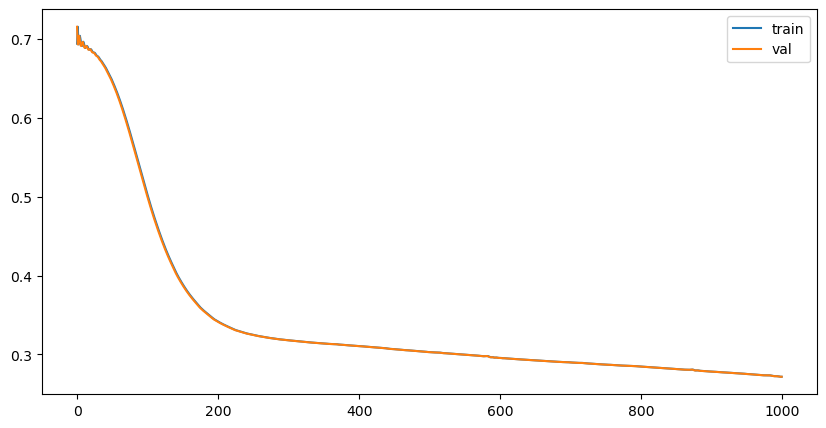

/home/pedro/anaconda3/lib/python3.10/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/home/pedro/anaconda3/lib/python3.10/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


ValueError: only one element tensors can be converted to Python scalars

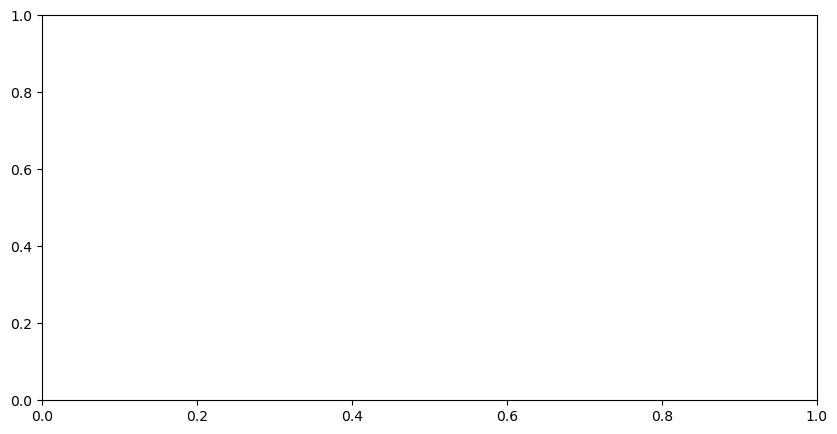

In [184]:

# train_losses, train_accs, val_losses, val_accs, test_acc = train(train_circle_loader, circle_val_loader, circle_test_loader, device, epochs=1000)

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accs, label="train")
plt.plot(val_accs, label="val")
plt.legend()
plt.show()

print(f"Test accuracy: {test_acc:.2f}")